In [58]:
import numpy as np

from numpy import random

import tqdm
import networkx as nx

class Agent:
    """
    Stolen from https://github.com/jweisber/sep-sen/blob/master/bg/agent.py
    Represents an agent in a network epistemology playground.
    
    Attributes:
    - credence: A float representing the agent's initial credence.
    - k: An integer representing the number of successful experiments.
    - n: An integer representing the total number of experiments.
    
    Methods:
    - __init__(self): Initializes the Agent object with random credence, k = 0, and n = 0.
    - __str__(self): Returns a string representation of the Agent object.
    - experiment(self, n, epsilon): Performs an experiment with the given parameters.
    - bayes_update(self, k, n, epsilon): Updates the agent's credence using Bayes' rule.
    - jeffrey_update(self, neighbor, epsilon, m): Updates the agent's credence using Jeffrey's rule.
    """
    
    def __init__(self,id):
        self.id = id
        self.credence = random.uniform(0, 1)
        self.k, self.n = 0, 0
    
    def __str__(self):
        return f"credence = {round(self.credence, 2)}, k = {self.k}, n = {self.n}"

    def experiment(self, n, epsilon):
        """
        Performs an experiment with the given parameters.
        
        Args:
        - n: An integer representing the total number of experiments.
        - epsilon: A float representing the uncertainty in the experiment.
        """
        if self.credence > .5:
            self.k = random.binomial(n, .5 + epsilon)
            self.n = n
        else:
            self.k, self.n = 0, 0
    
    def bayes_update(self, k, n, epsilon):
        """
        Updates the agent's credence using Bayes' rule.
        
        Args:
        - k: An integer representing the number of successful experiments.
        - n: An integer representing the total number of experiments.
        - epsilon: A float representing the uncertainty in the experiment.
        """
        self.credence = 1 / (1 + (1 - self.credence) * (((0.5 - epsilon) / (0.5 + epsilon)) ** (2 * k - n)) / self.credence)
    
    def jeffrey_update(self, neighbor, epsilon, m):
        """
        Updates the agent's credence using Jeffrey's rule.
        
        Args:
        - neighbor: An Agent object representing the neighbor agent.
        - epsilon: A float representing the uncertainty in the experiment.
        - m: A float representing the strength of the update.
        """
        n = neighbor.n
        k = neighbor.k
        
        p_E_H  = (0.5 + epsilon)**k * (0.5 - epsilon)**(n - k)         # P(E|H)  = p^k (1-p)^(n-k)
        p_E_nH = (0.5 - epsilon)**k * (0.5 + epsilon)**(n - k)         # P(E|~H) = (1-p)^k p^(n-k)
        p_E    = self.credence * p_E_H + (1 - self.credence) * p_E_nH  # P(E) = P(E|H) P(E) + P(E|~H) P(~H)
        
        p_H_E  = self.credence * p_E_H / p_E                           # P(H|E)  = P(H) P(E|H)  / P(E)
        p_H_nE = self.credence * (1 - p_E_H) / (1 - p_E)               # P(H|~E) = P(H) P(~E|H) / P(~E)
        
        # q_E = max(1 - abs(self.credence - neighbor.credence) * m * (1 - p_E), 0)  # O&W's Eq. 1 (anti-updating)
        q_E = 1 - min(1, abs(self.credence - neighbor.credence) * m) * (1 - p_E)    # O&W's Eq. 2

        self.credence = p_H_E * q_E + p_H_nE * (1 - q_E)               # Jeffrey's Rule # P'(H) = P(H|E) P'(E) + P(H|~E) P'(~E)#






class Zollman_model():

    def __init__(self, network, epsilon, n_experiments):
        self.network = network
        self.epsilon = epsilon
        self.n_agents = len(network.nodes)
        self.n_experiments = n_experiments
        self.agents = [Agent(i) for i in range(self.n_agents)]
    
        
    def step(self):
        for agent in self.agents:
            agent.experiment(self.n_experiments, self.epsilon)
        
        for agent in self.agents:
            neighbors = list(self.network.neighbors(agent.id))

            total_k, total_n = agent.k, agent.n
            for neighbor in [self.agents[x] for x in neighbors]:
                total_k += neighbor.k
                total_n += neighbor.n
            agent.bayes_update(total_k, total_n, self.epsilon)

    
    




                                       

In [63]:
my_network = nx.erdos_renyi_graph(10, 0.5)


my_model = Zollman_model(my_network, 0.01, 10)

print(my_model.agents[0].id)

my_model.step()
print(my_model.agents[0])
my_model.step()
print(my_model.agents[0])
my_model.step()
print(my_model.agents[0])
my_model.step()
print(my_model.agents[0])



# for this_step in tqdm.tqdm_notebook(range(100)):
#     my_model.step()
    
    # if my_model.converged == True:
    #     break


0
credence = 0.42, k = 0, n = 0
credence = 0.38, k = 0, n = 0
credence = 0.34, k = 0, n = 0
credence = 0.31, k = 0, n = 0


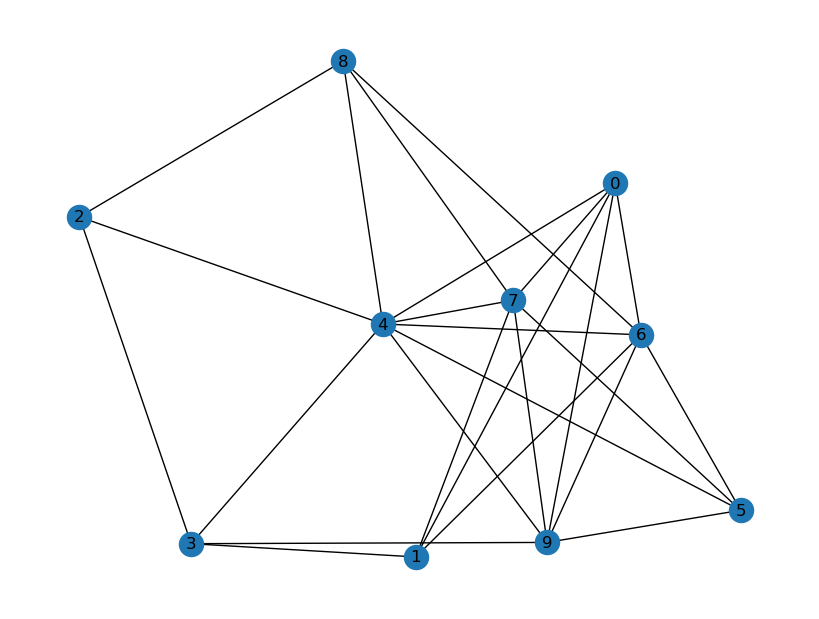

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
nx.draw(my_network, with_labels=True)
plt.show()


In [ ]:
from bg.agent import Agent
import numpy as np

class Graph:
    def __init__(self, a, shape):
        np.random.seed()
        self.agents = [Agent() for i in range(a)]
        self.graph = dict()
        self.epoch = 0

        if shape == "cycle":
            for i in range(a):
                self.graph[self.agents[i]] = [ self.agents[i - 1], self.agents[i], self.agents[(i + 1) % a] ]
        elif shape == "wheel":
            self.graph[self.agents[0]] = self.agents
            for i in range(1, a):
                self.graph[self.agents[i]] = [ self.agents[0], self.agents[i - 1], self.agents[i], self.agents[(i + 1) % a] ]
        elif shape == "complete":
            for i in range(a):
                self.graph[self.agents[i]] = self.agents
    
    def __str__(self):
        return "\n" + "\n".join([str(a) for a in self.agents])

    def run_simulation(self, n, epsilon, m):
        while(self.undecided() and not (m and self.polarized(m))):
            self.epoch += 1
            self.run_experiments(n, epsilon)
            if m:
                self.jeffrey_update_agents(epsilon, m)
            else:
                self.bayes_update_agents(epsilon)
        
        if m:
            self.conclusion = self.polarized(m)
        else:
            credences = np.array([a.credence for a in self.agents])
            self.conclusion = all(credences > .99)

    def run_experiments(self, n, epsilon):
        for a in self.agents:
            a.experiment(n, epsilon)

    def bayes_update_agents(self, epsilon):
        for a in self.agents:
            total_k, total_n = 0, 0
            for neighbor in self.graph[a]:
                total_k += neighbor.k
                total_n += neighbor.n
            if total_n > 0:
                a.bayes_update(total_k, total_n, epsilon)

    def jeffrey_update_agents(self, epsilon, m):
        for a in self.agents:
            for neighbor in self.graph[a]:
                if neighbor == a and a.n > 0:
                    a.bayes_update(a.k, a.n, epsilon)
                elif neighbor.n > 0:
                    a.jeffrey_update(neighbor, epsilon, m)

    def undecided(self):
        credences = np.array([a.credence for a in self.agents])
        return not (all(credences <= .5) or all(credences > .99))

    def polarized(self, m):
        credences = np.array([a.credence for a in self.agents])
        if all((credences < .5) | (credences > .99)) & any(credences < .5) & any(credences > .99):
            min_believer = min(credences[credences > .99])
            max_disbeliever = max(credences[credences < .5])
            d = min_believer - max_disbeliever
            return m * d >= 1
        else:
            return False